# Core Imports

In [18]:
# Custom Imports
from polysaccharide import general
from polysaccharide.extratypes import ResidueSmarts

from polysaccharide.molutils.rdmol import rdcompare, rdconvert, rdkdraw, rdcompare, rdprops, rdtypes, rdbond, rdlabels
from polysaccharide.polymer import monomer

# Generic Imports
import re
from functools import partial, cached_property
from collections import defaultdict
from itertools import combinations, chain
from ast import literal_eval

# Numeric imports
import pandas as pd
import numpy as np

# File I/O
from pathlib import Path
import csv, json, openpyxl

# Typing and Subclassing
from typing import Any, Callable, ClassVar, Generator, Iterable, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod, abstractproperty
from openmm.unit import Unit, Quantity

# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdChemReactions

# Static Paths
RAW_DATA = Path('raw_polymer_data')

## In-notebook display functions

In [19]:
def show_SMARTS(monomer_smarts : ResidueSmarts) -> None:
    '''Method for quickly showing SMARTS and molecular graph contents of Residue SMARTS'''
    for SMARTS in monomer_smarts.values():
        print(SMARTS)
        display(Chem.MolFromSmarts(SMARTS))

def show_SMILES(monomer_smiles : ResidueSmarts) -> None:
    '''Method for quickly showing SMILES and molecular graph contents of Residue SMILES'''
    for SMILES in monomer_smiles.values():
        print(SMILES)
        display(Chem.MolFromSmarts(SMILES))

# Inspecting NREL Urethanes

In [20]:
p = RAW_DATA / 'nipu_urethanes.xlsx'
df = pd.read_excel(p) # load from .xlsx file
df['Monomers'] = df['Monomers'].apply(literal_eval) # convert string of tuples into proper tuples

nipus     = df[df['Chemistry'] == 'NIPU'    ]
urethanes = df[df['Chemistry'] == 'urethane']

nipus_mono     = nipus['Monomers'].reset_index(drop=True) # extract monomers and renumber subset in-order
urethanes_mono = urethanes['Monomers'].reset_index(drop=True) # extract monomers and renumber subset in-order

In [21]:
# targ_mono = nipus_mono
targ_mono = {}

for i, monos in targ_mono.items():
    try:
        mono1, mono2 = monos
        rdmol1 = Chem.AddHs(rdmol1)
        display(rdmol1)
        
        print('='*50)
    except ValueError:
        print(f'Row {i} failed')

## Defining target functional groups

[#7:1](-[H:2])(-[H:3])-[H:4]


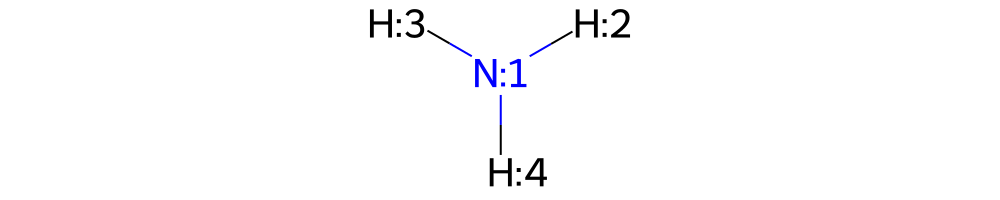

[#6:1]1(-[#8:2]-[#6:3](=[#8:4])-[#8:5]-[#6:6]-1(-[H:9])-[H:10])(-[H:7])-[H:8]


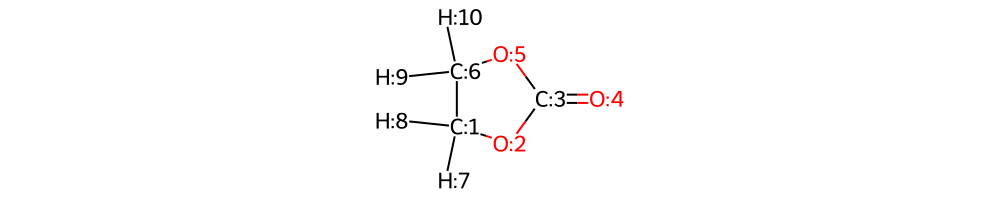

[#8:1](-[H:2])-[H:3]


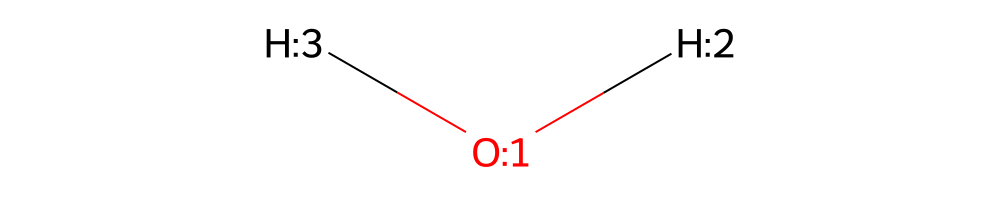

[#8:1]=[#6:2]=[#7:3]-[H:4]


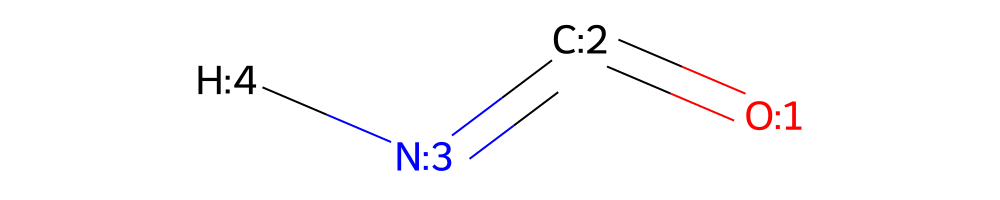

In [22]:
from polysaccharide.molutils.rdmol.rdtypes import RDMol
rdkdraw.set_rdkdraw_size(200, 5)

def labelled_smarts_mol(smiles : str) -> RDMol:
    rdmol = Chem.MolFromSmiles(smiles)
    rdmol = Chem.AddHs(rdmol)
    rdmol = rdlabels.assign_ordered_atom_map_nums(rdmol)

    return rdmol

fn_group_smiles_base = {
    'amine'          : '[NH3]',
    'cyclocarbonate' : 'C1OC(=O)OC1',
    'hydroxyl'       : '[OH2]',
    'isocyanate'     : 'O=C=N'
}

fn_group_smarts_portless = {}
for group_name, smiles in fn_group_smiles_base.items():
    fn_group_smarts_portless[group_name] = Chem.MolToSmarts(labelled_smarts_mol(smiles))

show_SMILES(fn_group_smarts_portless)

[#7:1](-[H:2])(-[H:3])-[*:4]


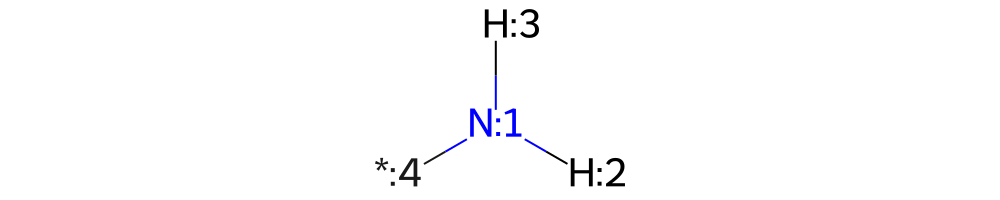

[#6:1]1(-[#8:2]-[#6:3](=[#8:4])-[#8:5]-[#6:6]-1(-[H:9])-[*:10])(-[H:7])-[*:8]


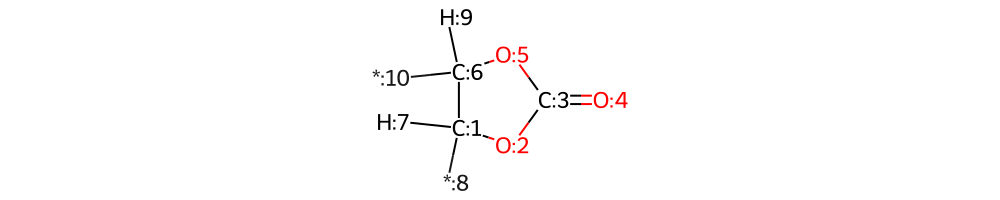

[#8:1](-[H:2])-[*:3]


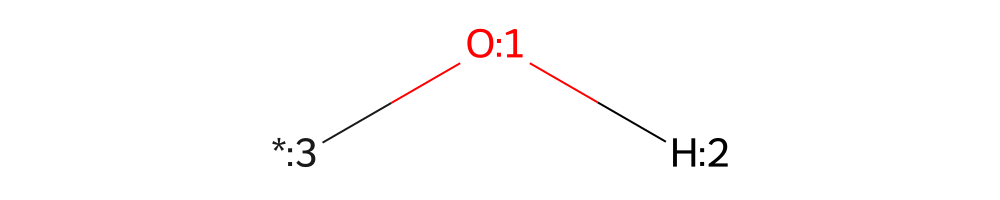

[#8:1]=[#6:2]=[#7:3]-[*:4]


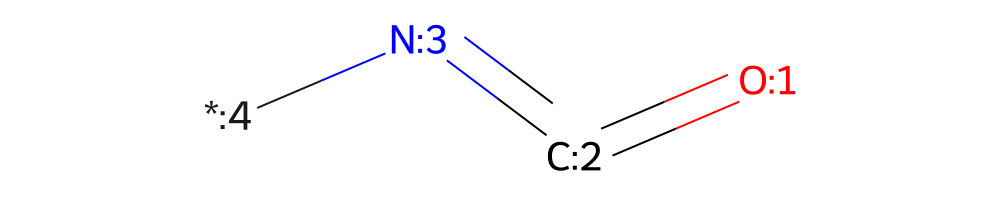

In [23]:
fn_group_smarts = { # add ports
    'amine'          : '[#7:1](-[H:2])(-[H:3])-[*:4]',
    'cyclocarbonate' : '[#6:1]1(-[#8:2]-[#6:3](=[#8:4])-[#8:5]-[#6:6]-1(-[H:9])-[*:10])(-[H:7])-[*:8]',
    'hydroxyl'       : '[#8:1](-[H:2])-[*:3]',
    'isocyanate'     : '[#8:1]=[#6:2]=[#7:3]-[*:4]'
}

fn_groups = {
    group : Chem.MolFromSmarts(smarts)
        for group, smarts in fn_group_smarts.items()
}

show_SMARTS(fn_group_smarts)

## Classify each monomer pair by respective reactive functional group

In [24]:
reaction_pairs = {
    'NIPU' : ('cyclocarbonate', 'amine'),
    'urethane' : ('isocyanate', 'hydroxyl')
}

results = []
for i, (chemistry, monomer_pair) in df.iterrows():
    monomer_entry = {
        'Chemistry' : chemistry
    }

    too_many_sites = False
    for SMILES in monomer_pair:
        rdmol = Chem.MolFromSmiles(SMILES)
        rdmol = Chem.AddHs(rdmol)

        for group_name, fn_group in fn_groups.items():
            matches = rdmol.GetSubstructMatches(fn_group)
            if matches and (group_name in reaction_pairs[chemistry]):
                monomer_entry[group_name] = Chem.MolToSmarts(rdmol)
            too_many_sites |= (len(matches) > 2) # OR with previous result; single true will make result true
        
    if not too_many_sites:        
        results.append(monomer_entry)

table = pd.DataFrame.from_records(results)
table

,Chemistry,amine,cyclocarbonate,hydroxyl,isocyanate
0,NIPU,[#7](-[#6](-[#6](-[#6](-[#6](-[#7](-[H])-[H])(...,[#6](-[#6](-[#6](-[#6](-[#6](-[#6](-[#6](-[#6]...,NaN,NaN
1,NIPU,[#7](-[#6](-[#6](-[#6](-[#7](-[#6](-[#6](-[#6]...,[#6](-[#6](-[#6](-[#6](-[#6](-[#6](-[#6](-[#6]...,NaN,NaN
2,NIPU,[#6](-[#6](-[#6](-[#6](-[#6](-[#6](-[#7](-[#6]...,[#8]=[#6]1-[#8]-[#6](-[#6](-[#6](-[#8]-[#6](-[...,NaN,NaN
3,NIPU,[#6](-[#6](-[#6](-[#6](-[#6](-[#6](-[#6](-[#6]...,[#8]=[#6]1-[#8]-[#6](-[#6](-[#6](-[#8]-[#6](-[...,NaN,NaN
4,NIPU,[#7](-[#6](-[#6](-[#8]-[#6](-[#6](-[#8]-[#6](-...,[#6](-[#6](-[#6](-[#6](-[#6](-[#6](-[#6](-[#6]...,NaN,NaN
...,...,...,...,...,...
71,urethane,NaN,NaN,[#8](-[#6](-[#6](-[#6](-[#6](-[#6](-[#6](-[#8]...,[#8]=[#6]=[#7]-[#6](-[#6](-[#6](-[#6](-[#6](-[...
72,urethane,NaN,NaN,[#8](-[#6](-[#6](-[#8]-[H])(-[H])-[H])(-[H])-[...,[#8]=[#6]=[#7]-[#6]1:[#6](:[#6](:[#6](-[#6](-[...
73,urethane,NaN,NaN,[#8](-[#6](-[#6](-[#6](-[#6](-[#8]-[H])(-[H])-...,[#8]=[#6]=[#7]-[#6](-[#6](-[#6](-[#6](-[#6](-[...
74,urethane,NaN,NaN,[#8](-[#6](-[#6](-[#8]-[H])(-[H])-[H])(-[H])-[...,[#8]=[#6]=[#7]-[#6](-[#6](-[#6](-[#6](-[#6](-[...


# Defining polymerization reactions

In [25]:
rdkdraw.set_rdkdraw_size(400, 3/2)
rxn_eqns, rxns = {}, {}

## Reaction information classes

In [26]:
@dataclass
class RxnProductInfo:
    '''For storing atom map numbers associated with product atoms and bonds participating in a reaction'''
    prod_num : int
    reactive_atom_map_nums : list[int] = field(default_factory=list)

    new_bond_ids_and_map_nums : dict[int, tuple[int, int]] = field(default_factory=dict)
    mod_bond_ids_and_map_nums : dict[int, tuple[int, int]] = field(default_factory=dict)
    
class AnnotatedReaction(rdChemReactions.ChemicalReaction):
    '''RDKit ChemicalReaction with additional useful information about product atom and bond mappings'''
    @classmethod
    def from_rdmols(cls, reactant_templates : Iterable[RDMol], product_templates : Iterable[RDMol]) -> 'AnnotatedReaction':
        '''For instantiating reactions directly frommolecules instead of SMARTS strings'''
        react_str = '.'.join(Chem.MolToSmarts(react_template) for react_template in reactant_templates)
        prod_str  = '.'.join(Chem.MolToSmarts(prod_template) for prod_template in product_templates)
        rxn_eqn = f'{react_str}>>{prod_str}'
        rdrxn = rdChemReactions.ReactionFromSmarts(rxn_eqn)

        return cls(rdrxn) # pass to init method

    @cached_property
    def reacting_atom_map_nums(self) -> list[int]:
        '''List of the map numbers of all reactant atoms which participate in the reaction'''
        return [
            self.GetReactantTemplate(react_num).GetAtomWithIdx(atom_id).GetAtomMapNum()
                for react_num, reacting_atom_ids in enumerate(self.GetReactingAtoms())
                    for atom_id in reacting_atom_ids
        ]
    
    @cached_property
    def map_nums_to_reactant_nums(self) -> dict[int, int]:
        '''Back-map yielding the index of the source reactant for the atom of each map number'''
        return {
            atom.GetAtomMapNum() : i
                for i, react_template in enumerate(self.GetReactants())
                    for atom in react_template.GetAtoms()
        }
    
    @cached_property
    def product_info_maps(self) -> dict[int, RxnProductInfo]:
        '''Map from product index to information about reactive atoms and bonds in that product'''
        # map reacting atoms and bonds for each product
        prod_info_map = {}
        for i, product_template in enumerate(self.GetProducts()):
            prod_info = RxnProductInfo(i)
            prod_info.reactive_atom_map_nums = [
                map_num
                    for map_num in self.reacting_atom_map_nums
                        if map_num in rdlabels.get_ordered_map_nums(product_template)
            ]

            for bond_id, atom_id_pair in rdbond.get_bonded_pairs_by_map_nums(product_template, *prod_info.reactive_atom_map_nums).items(): # consider each pair of reactive atoms
                map_num_1, map_num_2 = map_num_pair = tuple(
                    product_template.GetAtomWithIdx(atom_id).GetAtomMapNum()
                        for atom_id in atom_id_pair
                )
                
                if self.map_nums_to_reactant_nums[map_num_1] == self.map_nums_to_reactant_nums[map_num_2]: # if reactant IDs across bond match, the bond must have been modified (i.e. both from single reactant...)
                    prod_info.mod_bond_ids_and_map_nums[bond_id] = map_num_pair
                else: # otherwise, bond must be newly formed (spans between previously disjoint monomers) 
                    prod_info.new_bond_ids_and_map_nums[bond_id] = map_num_pair
            prod_info_map[i] = prod_info
        
        return prod_info_map
    
    

## NIPU reaction

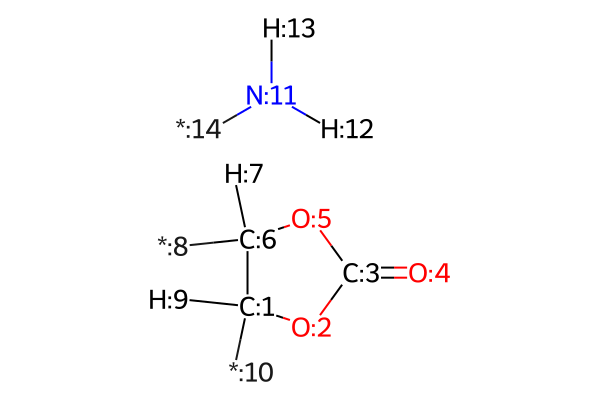

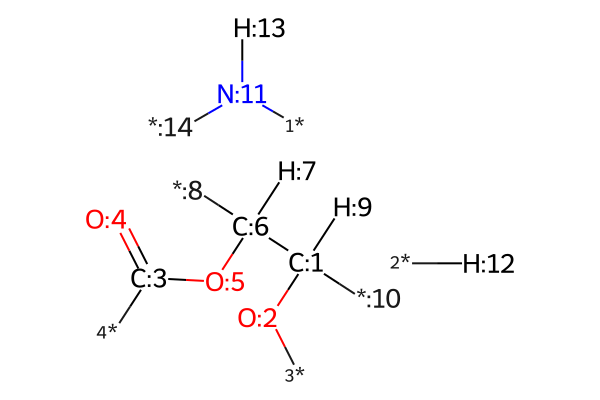

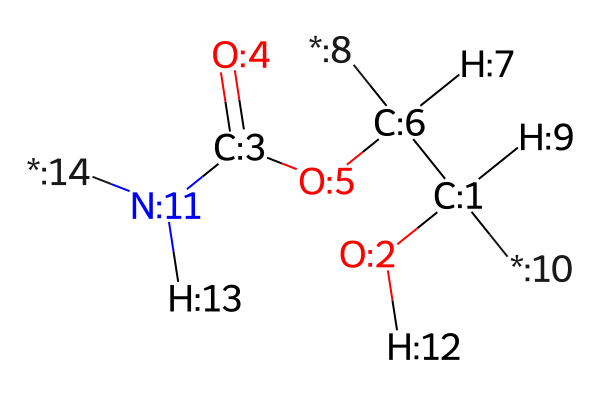

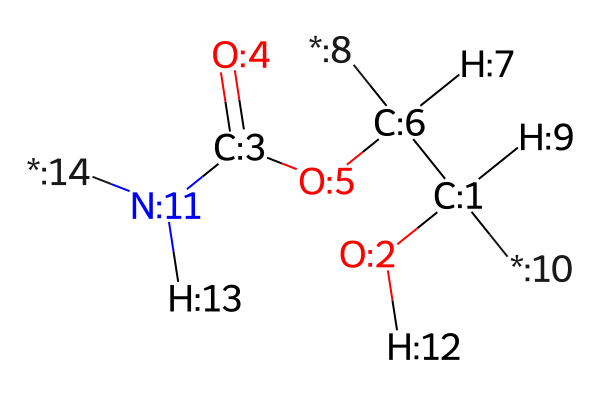

In [27]:
# 1a) extracting and labelling reactants
reactant1, reactant2 = rdlabels.assign_serial_atom_map_nums(fn_groups['cyclocarbonate'], fn_groups['amine'], in_place=False)
reactant1_SMARTS = Chem.MolToSmarts(reactant1) 
reactant2_SMARTS = Chem.MolToSmarts(reactant2) 
reactants = Chem.MolFromSmarts(f'{reactant1_SMARTS}.{reactant2_SMARTS}')

# 1b) defining product mixture
product = Chem.RWMol(reactants) # create editable Mol
display(product)

# 2) cleaving broken bonds
bond_break_map_nums = ( # definig bonds to break my atom map num
    (11, 12),
    (2, 3)
)
for atom_pair in bond_break_map_nums:
    rdbond.decrease_bond_order(
        product,
        *rdlabels.atom_ids_by_map_nums(product, *atom_pair),
        dummyLabels=True,
        in_place=True
    )
display(product)

# 3) forming new bonds with cleaved groups
bond_make_map_nums = (
    (11, 3),
    (2, 12)
)
for atom_pair in bond_make_map_nums:
    rdbond.increase_bond_order(
        product,
        *rdlabels.atom_ids_by_map_nums(product, *atom_pair),
        prioritize_unlabelled_ports=True,
        in_place=True
    )
display(product)
    
# 4) delete ports created during bond breaking (!!important that this be done last!!)
rdlabels.clear_atom_isotopes(product, in_place=True)
display(product)

# defining reaction
rxns['NIPU'] = AnnotatedReaction.from_rdmols(reactant_templates=[reactant1, reactant2], product_templates=[product])

## Urethane reaction

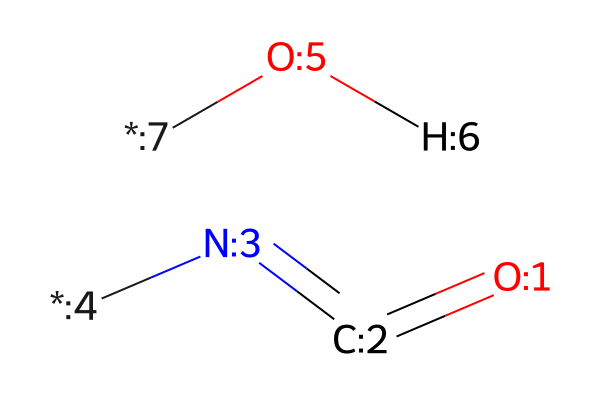

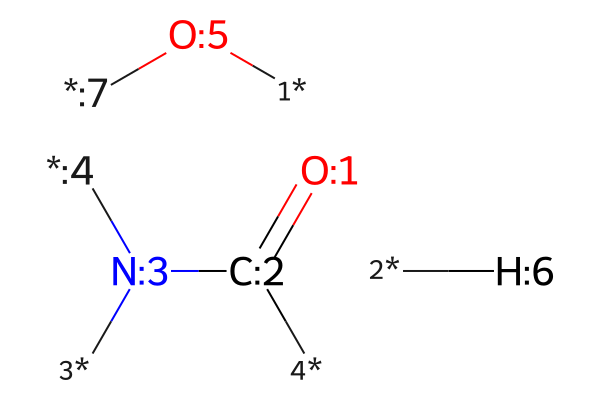

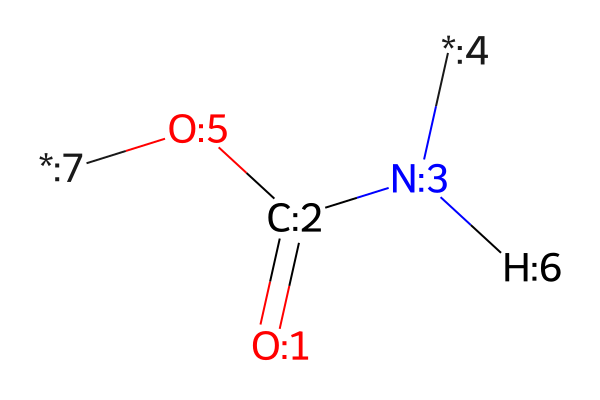

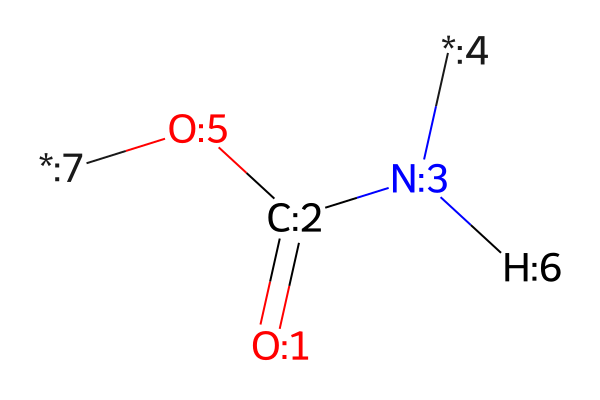

In [28]:
# 1a) extracting and labelling reactants
reactant1, reactant2 = rdlabels.assign_serial_atom_map_nums(fn_groups['isocyanate'], fn_groups['hydroxyl'], in_place=False)
reactant1_SMARTS = Chem.MolToSmarts(reactant1) 
reactant2_SMARTS = Chem.MolToSmarts(reactant2) 
reactants = Chem.MolFromSmarts(f'{reactant1_SMARTS}.{reactant2_SMARTS}')

# 1b) defining product mixture
product = Chem.RWMol(reactants) # create editable Mol
display(product)

# 2) cleaving broken bonds
bond_break_map_nums = ( # definig bonds to break my atom map num
    (5, 6),
    (3, 2)
)
for atom_pair in bond_break_map_nums:
    rdbond.decrease_bond_order(
        product,
        *rdlabels.atom_ids_by_map_nums(product, *atom_pair),
        dummyLabels=True,
        in_place=True
    )
display(product)

# 3) forming new bonds with cleaved groups
bond_make_map_nums = (
    (3, 6),
    (5, 2)
)
for atom_pair in bond_make_map_nums:
    rdbond.increase_bond_order(
        product,
        *rdlabels.atom_ids_by_map_nums(product, *atom_pair),
        prioritize_unlabelled_ports=True,
        in_place=True
    )
display(product)
    
# 4) delete ports created during bond breaking (!!important that this be done last!!)
rdlabels.clear_atom_isotopes(product, in_place=True)
display(product)

# defining reaction
rxns['urethane'] = AnnotatedReaction.from_rdmols(reactant_templates=[reactant1, reactant2], product_templates=[product])

## Testing reaction replacement rules

In [32]:
@dataclass
class Reactor:
    '''Class for executing a reaction template on collections of RDMol "reactants"'''
    rxn_schema : AnnotatedReaction
    reactants : Iterable[RDMol]
    products  : Optional[Iterable[RDMol]] = field(init=False, default=None)
    _has_reacted : bool = field(init=False, default=False)

    _ridx_prop_name : ClassVar[str] = field(init=False, default='reactant_idx') # name of the property to assign reactant indices to; set for entire class

    # PRE-REACTION PREPARATION METHODS
    def _activate_reaction(self) -> None:
        '''Check that the reaction schema provided is well defined and initialized'''
        pass

    def _mark_reactants(self) -> None:
        '''Assigns "reactant_idx" Prop to all reactants to help track where atoms go during the reaction'''
        for i, reactant in enumerate(self.reactants):
            for atom in reactant.GetAtoms():
                atom.SetIntProp(self._ridx_prop_name, i)

    def __post_init__(self) -> None:
        '''Pre-processing of reaction and reactant Mols'''
        self._activate_reaction()
        self._mark_reactants()

    # POST-REACTION CLEANUP METHODS
    @classmethod
    def _remark_reacted_atoms(cls, product : RDMol, reactant_map_nums : dict[int, int]) -> None:
        '''Re-assigns "reactant_idx" Prop to modified reacted atoms to re-complete atom-to-reactant numbering'''
        for atom_id in rdprops.atom_ids_with_prop(product, 'old_mapno'):
            atom = product.GetAtomWithIdx(atom_id)
            map_num = atom.GetIntProp('old_mapno')

            atom.SetIntProp(cls._ridx_prop_name, reactant_map_nums[map_num])
            atom.SetAtomMapNum(map_num) # TOSELF : in future, might remove this (makes mapping significantly easier, but is ugly for labelling)

    @staticmethod
    def _sanitize_bond_orders(product : RDMol, product_template : RDMol, product_info : RxnProductInfo) -> None:
        '''Ensure bond order changes specified by the reaction are honored by RDKit'''
        for prod_bond_id, map_num_pair in product_info.mod_bond_ids_and_map_nums.items():
            target_bond  : rdtypes.RDBond= product_template.GetBondWithIdx(prod_bond_id)

            # product_bond : rdtypes.RDBond = rdbond.get_bond_by_map_num_pair(product, map_num_pair)
            product_bond : rdtypes.RDBond = product.GetBondBetweenAtoms(*rdlabels.atom_ids_by_map_nums(product, *map_num_pair))
            assert(product_bond.GetBeginAtom().HasProp('_ReactionDegreeChanged')) 
            assert(product_bond.GetEndAtom().HasProp('_ReactionDegreeChanged')) # double check that the reaction agrees that the bond has changed

            product_bond.SetBondType(target_bond.GetBondType()) # set bond type to what it *should* be from the reaction schema

    # REACTION EXECUTION METHODS
    def react(self, repetitions : int=1) -> None:
        '''Execute reaction and generate product molecule'''
        self.products = [
            product # unroll nested tuples that RDKit provides as reaction products
                for product in chain.from_iterable(self.rxn_schema.RunReactants(self.reactants, maxProducts=repetitions))
        ]
        self._has_reacted = True # set reaction flag

        # post-reaction cleanup
        for i, product in enumerate(self.products): # TODO : generalize to work when more than 1 repetition is requested
            self._remark_reacted_atoms(product, self.rxn_schema.map_nums_to_reactant_nums)
            self._sanitize_bond_orders(product,
                product_template=self.rxn_schema.GetProductTemplate(i),
                product_info=self.rxn_schema.product_info_maps[i]
            )

@dataclass
class CondensationReactor(Reactor):
    '''Special case of Reactor with two reactant species forming one product'''
    def __post_init__(self) -> None:
        assert(self.rxn_schema.GetNumReactantTemplates() == 2)
        assert(self.rxn_schema.GetNumProductTemplates() == 1)

        return super().__post_init__()
    
    @property
    def product(self) -> RDMol:
        return self.products[0]
    
    @property
    def product_info(self) -> RDMol:
        return self.rxn_schema.product_info_maps[0]

@dataclass
class PolymerizationReactor(CondensationReactor):
    '''Reactor which handles monomer partitioning post-polymerization condensation reaction'''
    def inter_monomer_bond_candidates(self, valid_backbone_atoms : tuple[str]=('C', 'N', 'O')) -> list[int]:
        '''Returns the bond index of the most likely candidate for a newly-formed bond in the product which was formed between the reactants
        Can optionally define which atoms are valid as main-chain atoms (by default just CNO)'''
        possible_bridgehead_ids = [ # determine all atomic positions which are: 
            atom_id
                for atom_id in rdprops.atom_ids_with_prop(self.product, 'was_dummy')           # 1) former ports (i.e. outside of monomers)
                    if self.product.GetAtomWithIdx(atom_id).GetSymbol() in valid_backbone_atoms # 2) valid backbone atoms (namely, not hydrogens)
        ]
        
        return [
            new_bond_id
                for new_bond_id in self.product_info.new_bond_ids_and_map_nums.keys()  # for each newly formed bond...
                    for bridgehead_id_pair in combinations(possible_bridgehead_ids, 2) # ...find the most direct path between bridgehead atoms...
                        if new_bond_id in rdbond.get_shortest_path_bonds(self.product, *bridgehead_id_pair) # ...and check if the new bond lies along it
        ]

    @property
    def polymerized_fragments(self) -> RDMol:
        '''Cut product on inter-monomer bond, returning the resulting fragments'''
        clean_product = rdlabels.clear_atom_map_nums(self.product, in_place=False)
        return Chem.FragmentOnBonds(clean_product, bondIndices=[self.inter_monomer_bond_candidates()[0]])

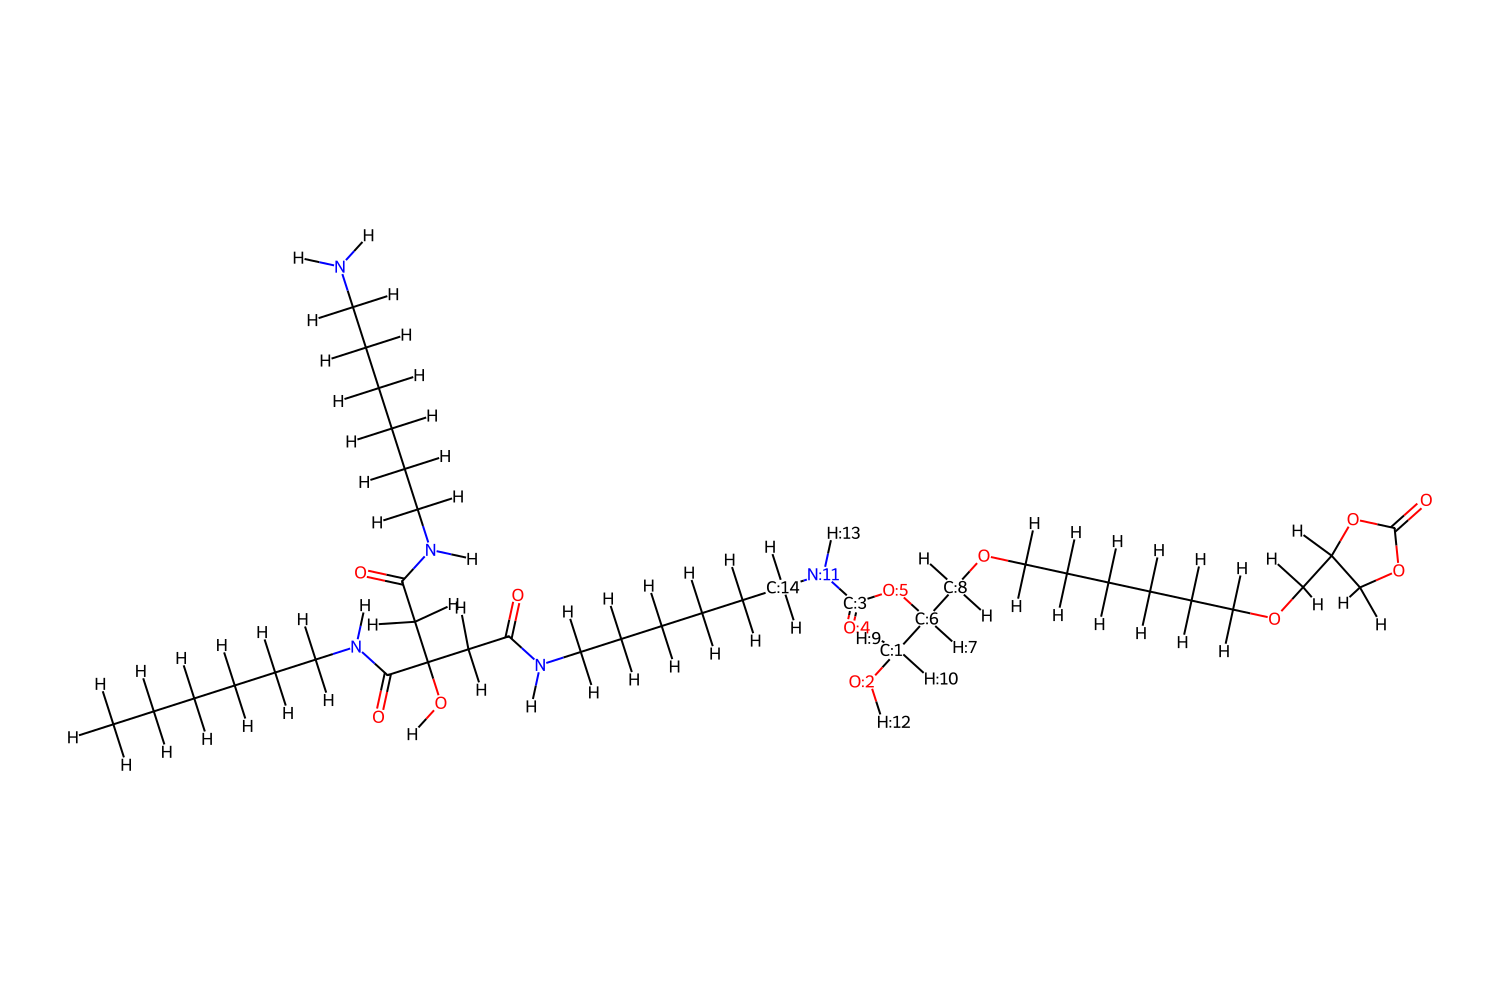

[6]


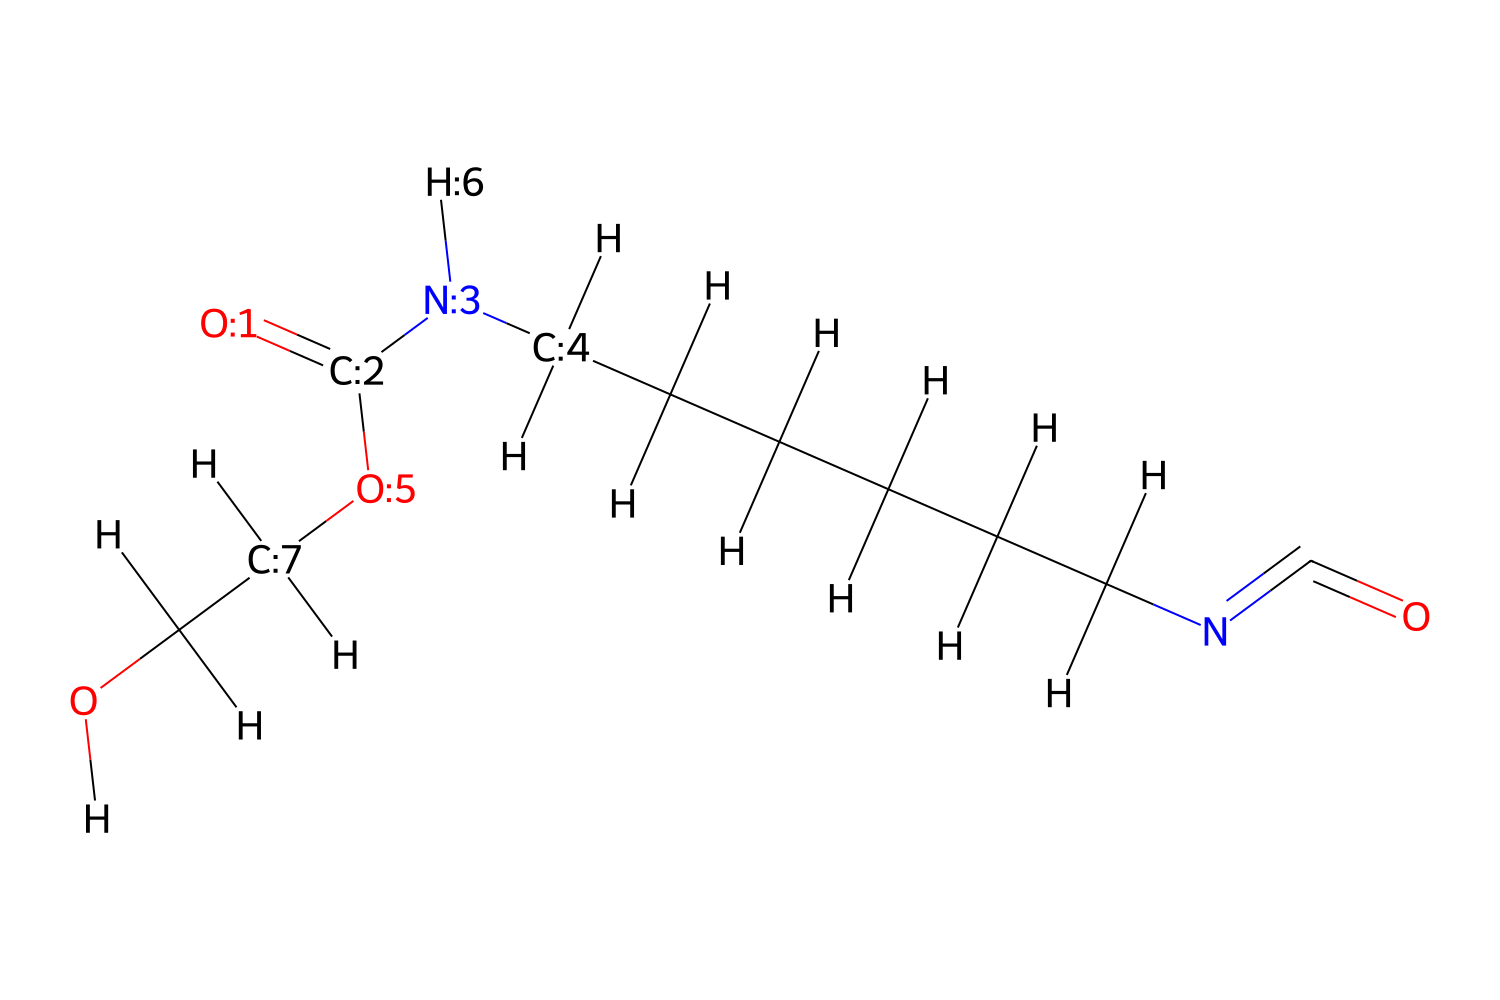

[4]


In [35]:
# for j, sample in table.tail(2).iterrows():
# for j, sample in table.head(5).iterrows():

rdkdraw.set_rdkdraw_size(1000, 3/2)
for sample in (table.iloc[2], table.iloc[-2]):
    chemistry = sample['Chemistry']

    reactants = [
        Chem.MolFromSmarts(sample[group_name])
            for i, group_name in enumerate(reaction_pairs[chemistry])
    ]
    rxn = rxns[chemistry]
    reactor = PolymerizationReactor(rxn, reactants=reactants)

    reactor.react()
    dimer = reactor.products[0]
    
    # label former ports
    # for atom_id in rdprops.atom_ids_with_prop(dimer, 'was_dummy'):
    #     atom = dimer.GetAtomWithIdx(atom_id)
    #     atom.SetProp('atomNote', f'{atom_id}_{atom.GetIntProp("reactant_idx")}_{atom.GetAtomicNum()}')

    # # Correcting order-modified bonds post-reaction
    # prod_group = rxn.GetProductTemplate(0)
    # prod_info = rxn.product_info_maps[0]

    # for prod_group_bond_id, mod_bond_map_num_pair in prod_info.mod_bond_ids_and_map_nums.items():
    #     dimer_bond = rdbond.get_bond_by_map_num_pair(dimer, mod_bond_map_num_pair)
    #     dimer_bond.SetProp('bondNote', f'mod_{dimer_bond.GetIdx()}') # set bond type to what it *should* be from the reaction schema

    # for prod_group_bond_id, new_bond_map_num_pair in prod_info.new_bond_ids_and_map_nums.items():
    #     dimer_bond = rdbond.get_bond_by_map_num_pair(dimer, new_bond_map_num_pair)
    #     dimer_bond.SetProp('bondNote', f'new_{dimer_bond.GetIdx()}') # set bond type to what it *should* be from the reaction schema

    display(dimer)
    print(reactor.inter_monomer_bond_candidates())

(<rdkit.Chem.rdchem.Mol at 0x7fefdf55aff0>,
 <rdkit.Chem.rdchem.Mol at 0x7fefdf55b1b0>)

In [39]:
r2 = PolymerizationReactor(rxn, Chem.GetMolFrags(reactor.polymerized_fragments, asMols=True))

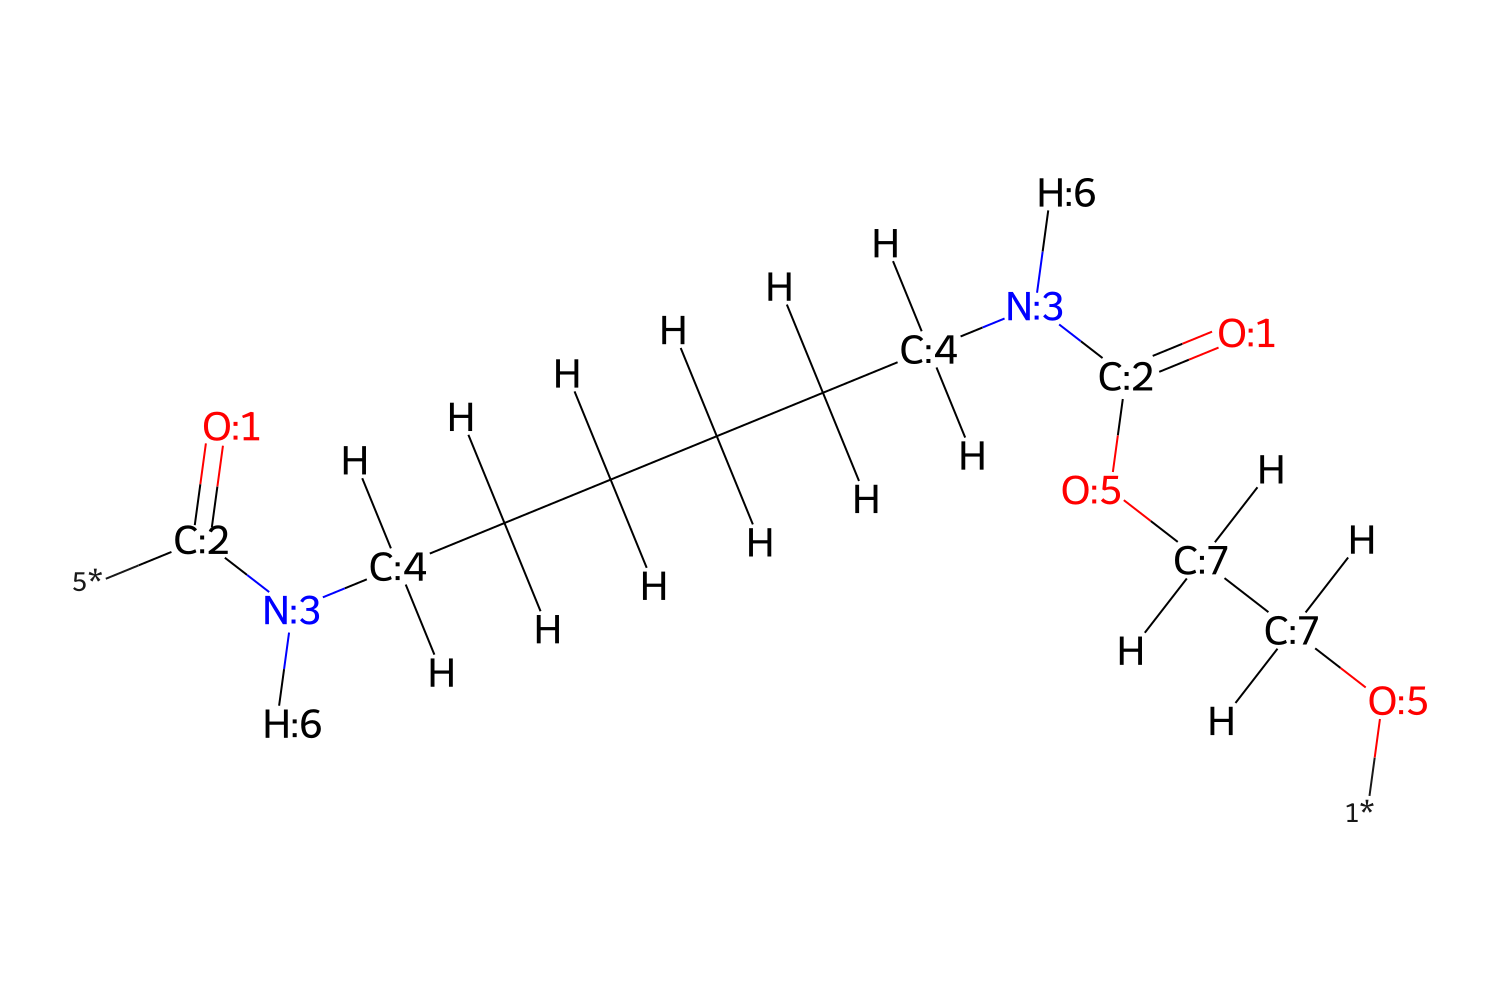

In [40]:
r2.react()
r2.product

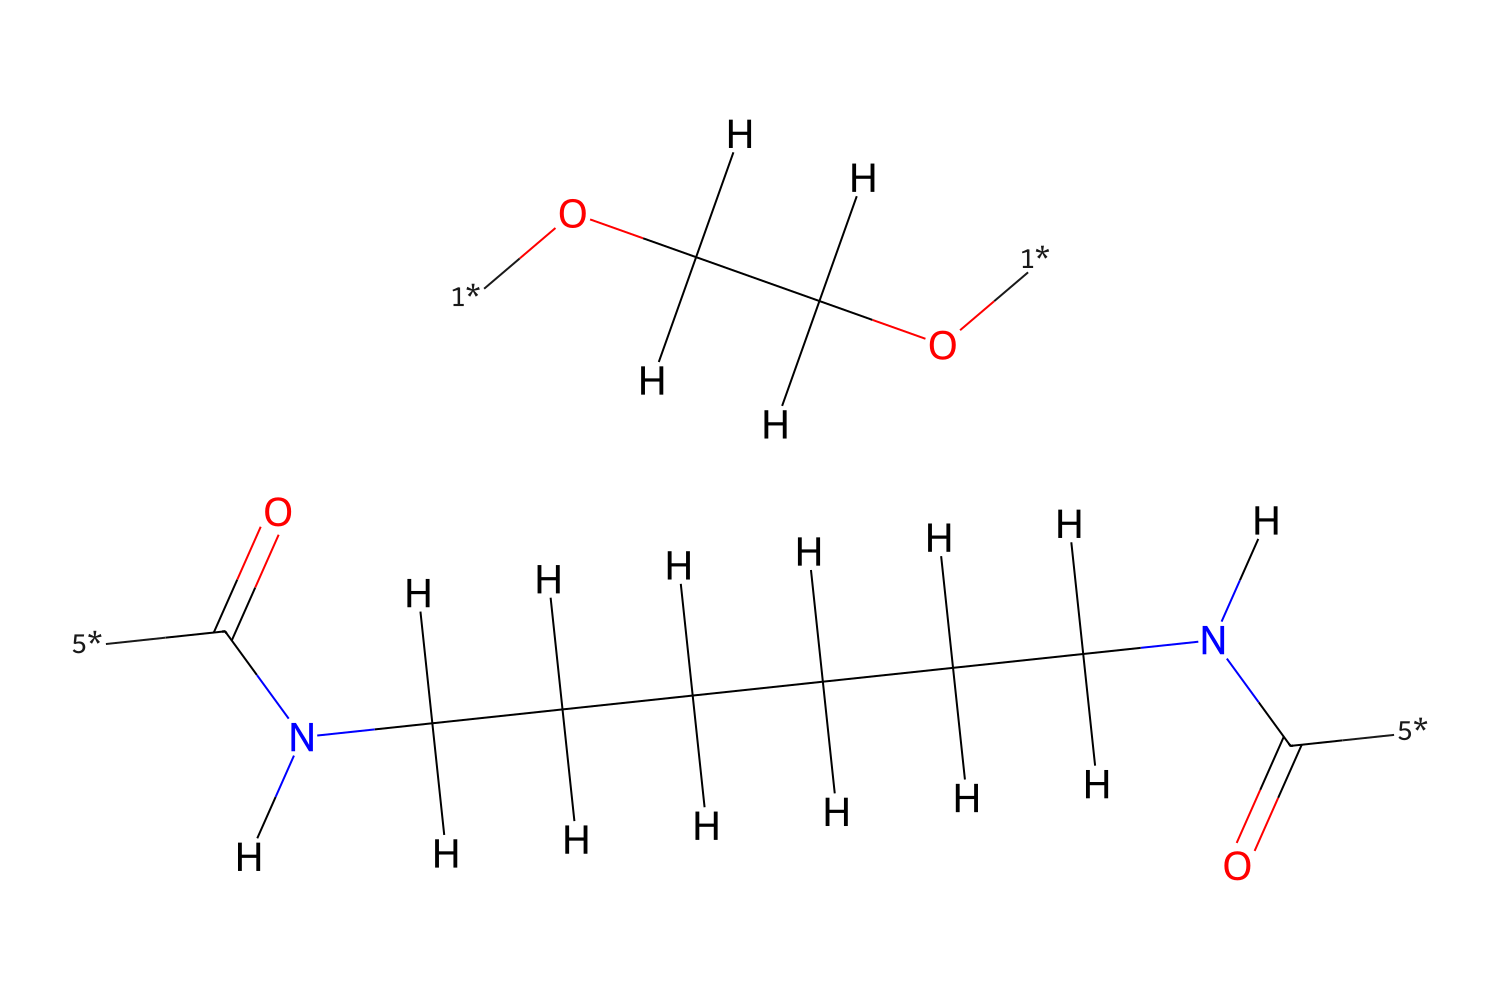

In [41]:
r2.polymerized_fragments